In [1]:
%load_ext autoreload
%autoreload 2

# Recommending popular items

This tutorial shows how to create custom response function and use it in Sim4Rec.


### Users
5000 anonymous users

### Items
10 items

### Response function
Users are more likely to choose the most popular items.


## Imports and preparations

In [2]:
import os
import sys
os.environ["PYSPARK_PYTHON"]=sys.executable
os.environ["PYSPARK_DRIVER_PYTHON"]=sys.executable

In [3]:
!pip list | grep "replay"

replay-rec                    0.10.0      /home/anna/airi_summer_school23/RePlay


In [4]:
import random
import time

import pandas as pd
import numpy as np

import pyspark.sql.functions as sf
from pyspark import SparkConf
from pyspark.ml import PipelineModel
from pyspark.sql import SparkSession

from replay.models import UCB
from replay.session_handler import State
from replay.utils import get_top_k_recs

# path to spark tmp folder and simulator checkpoints
SPARK_LOCAL_DIR = './tmp/task_1'
CHECKPOINT_DIR = './tmp/task_1_checkpoints'

In [5]:
from sim4rec.modules import RealDataGenerator
from sim4rec.modules import Simulator

from response_models.task_1_popular_items import TaskOneResponse
from response_models.utils import plot_metric, calc_metric

In [6]:
%%bash -s "$CHECKPOINT_DIR" "$SPARK_LOCAL_DIR"
# simulator saves the interaction history between users and recommender system
# to rerun the simulation cycle or begin a new one, clear the directory or use another CHECKPOINT_DIR
rm -rf $1 $2

In [7]:
NUM_THREADS = 4

spark = SparkSession.builder\
    .appName('simulator')\
    .master(f'local[{NUM_THREADS}]')\
    .config('spark.sql.shuffle.partitions', f'{NUM_THREADS * 3}')\
    .config('spark.default.parallelism', f'{NUM_THREADS * 3}')\
    .config('spark.driver.extraJavaOptions', '-XX:+UseG1GC')\
    .config('spark.executor.extraJavaOptions', '-XX:+UseG1GC')\
    .config('spark.local.dir', SPARK_LOCAL_DIR)\
    .getOrCreate()

State(spark)
spark.sparkContext.setLogLevel('ERROR')

23/07/13 17:58:55 WARN Utils: Your hostname, trans4rec resolves to a loopback address: 127.0.1.1; using 192.168.1.13 instead (on interface ens160)
23/07/13 17:58:55 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
23/07/13 17:58:57 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/07/13 17:58:58 WARN SparkConf: Note that spark.local.dir will be overridden by the value set by the cluster manager (via SPARK_LOCAL_DIRS in mesos/standalone/kubernetes and LOCAL_DIRS in YARN).
23/07/13 17:59:00 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
23/07/13 17:59:00 WARN Utils: Service 'SparkUI' could not bind on port 4041. Attempting port 4042.
23/07/13 17:59:00

In [8]:
NUM_USERS = 5000
NUM_ITEMS = 10
# number of recommendations generated by recommender system per user per one iteration
K = 1
# number of iterations
NUM_ITER = 20
SEED = 1234

## Data

In [9]:
users = spark.createDataFrame([[x] for x in range(NUM_USERS)], schema=["user_idx"])
items = spark.createDataFrame([[x] for x in range(NUM_ITEMS)], schema=["item_idx"])
items.show(2)

+--------+
|item_idx|
+--------+
|       0|
|       1|
+--------+
only showing top 2 rows



In [10]:
item_generator = RealDataGenerator(label='items_real', seed=SEED)
user_generator = RealDataGenerator(label='users_real', seed=SEED)

item_generator.fit(items)
user_generator.fit(users)

item_generator.generate(NUM_ITEMS)
user_generator.generate(NUM_USERS)

DataFrame[user_idx: bigint]

# One iteration of simulation cycle step by step

## (1) Choise of users

In [11]:
user_generator.sample(0.1).count()

504

## (2) Choise of items
During simulation cycle all 10 items will be avaliable at each iteration.

## (3) Initialization of recommender model

### Baseline

In [12]:
model = UCB(sample=True, seed=SEED, exploration_coef=0.1)
# RePlay model should be fitted on historic data before it can be refitted in cycle
# Let's assume we had one interaction for simplicity
model.fit(log=users.limit(1).crossJoin(items.limit(1)).withColumn("relevance", sf.lit(1)))

In [13]:
pred = model.predict(log=None, users=users.limit(2), items=items, k=3)
pred.show(6)

+--------+--------+---------+
|user_idx|item_idx|relevance|
+--------+--------+---------+
|       0|       6|      0.1|
|       0|       1|      0.1|
|       0|       7|      0.1|
|       1|       3|      0.1|
|       1|       9|      0.1|
|       1|       8|      0.1|
+--------+--------+---------+



## (4) Response Function

Response function in this tutorial is very simple. The response is binary, response == 1 means that user bought the item. The probability of response is proportional to the popularity of item in the past. Response function is constant in time.

Response function gets dataframe with columns <user_idx, item_idx, relevance>, and returns dataframe with columns <user_idx, item_idx, relevance, response>, adding the response column to the initial ones. If the initial dataframe had some other columns, they will be returned as well.

In [15]:
!pwd

/home/anna/airi_summer_school23


In [15]:
popularity_model = TaskOneResponse(spark=spark, seed=SEED)

Example how the response is generated for user-item pair

In [16]:
test_response = popularity_model.transform(pred)
test_response.show()


[Stage 68:>                                                         (0 + 1) / 1]



+--------+--------+---------+--------+
|item_idx|user_idx|relevance|response|
+--------+--------+---------+--------+
|       6|       0|      0.1|       0|
|       1|       0|      0.1|       0|
|       7|       0|      0.1|       0|
|       3|       1|      0.1|       0|
|       9|       1|      0.1|       1|
|       8|       1|      0.1|       1|
+--------+--------+---------+--------+



## (5) Refitting of recommender model

After receiving responses for recommendations we can use this information to update the recommender model. To do that, we should rename column response to relevance.

In [17]:
new_log = test_response.drop("relevance").withColumnRenamed("response", "relevance")
new_log.show()

+--------+--------+---------+
|item_idx|user_idx|relevance|
+--------+--------+---------+
|       6|       0|        0|
|       1|       0|        0|
|       7|       0|        0|
|       3|       1|        0|
|       9|       1|        1|
|       8|       1|        1|
+--------+--------+---------+



In [18]:
### YOUR CODE HERE
model.refit(log=test_response.drop("relevance").withColumnRenamed("response", "relevance"))
###

## (6) Quality of recommendations

Quality is the mean number of positive responses per user.

In [19]:
calc_metric(test_response)

1.0

# Training the model in simulator

In [20]:
%%bash -s "$CHECKPOINT_DIR"
rm -rf $1

## Initialization of simulator

In [21]:
user_generator.initSeedSequence(SEED)
item_generator.initSeedSequence(SEED)

sim = Simulator(
    user_gen=user_generator,
    item_gen=item_generator,
    data_dir=f'{CHECKPOINT_DIR}/pipeline',
    user_key_col='user_idx',
    item_key_col='item_idx',
    spark_session=spark
)

### Check that format is correct

In [23]:
pred = model.predict(log=None, users=users.limit(10), items=items, k=K)
###

assert pred.columns == ["user_idx", "item_idx", "relevance"]
assert pred.groupBy('user_idx').agg(sf.countDistinct("item_idx").alias("num_items")).filter(sf.col("num_items") == sf.lit(K)).count() == 10
assert pred.groupBy('user_idx').agg(sf.count("item_idx").alias("num_items")).filter(sf.col("num_items") == sf.lit(K)).count() == 10

## Response function initialization

In [24]:
popularity_model = TaskOneResponse(seed=SEED, spark=spark)

## Simulation cycle

In [25]:
# run this if you didn't end the simulation cycle
# current_users.unpersist()
# if log is not None:
#     log.unpersist()
# recs.unpersist()
# true_resp.unpersist()
# train_log..unpersist()

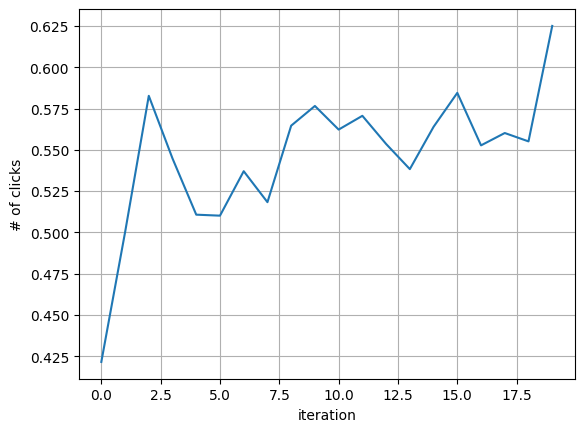

Iteration 19 finished in 5.989673376083374 sec.


In [26]:
metrics = []
for i in range(NUM_ITER):
    print(f'Iteration {i} started')
    iter_time = time.time()
    # users that will buy items
    current_users = sim.sample_users(0.1).cache()
    # history of interactions
    log = sim.get_log(users)

    recs = model.predict(
        log=log,
        k=K,
        users=current_users,
        items=items,
        filter_seen_items=False
    ).cache()
    ###
    
    assert (recs
            .groupBy('user_idx')
            .agg(sf.count("item_idx").alias("num_items"))
            .filter(sf.col("num_items") == sf.lit(K))
            .count() 
            == 
            current_users.count()
           )
    
    # getting responses
    true_resp = sim.sample_responses(
        recs_df=recs,
        user_features=current_users,
        item_features=items,
        action_models=popularity_model
    ).cache()

    # update the interaction history
    sim.update_log(true_resp, iteration=i)

    # measure quality
    metrics.append(calc_metric(true_resp))

    # refitting the model
    model._clear_cache()
    train_log = sim.log.cache()
    model.fit(
        log=train_log.select('user_idx', 'item_idx', 'response')\
                     .withColumnRenamed('response', 'relevance')
        )
    ###

    current_users.unpersist()
    if log is not None:
        log.unpersist()
    recs.unpersist()
    true_resp.unpersist()
    train_log.unpersist()

    plot_metric(metrics)
    print(f'Iteration {i} finished in {time.time() - iter_time} sec.')

In [27]:
sim.log.filter(sf.col("__iter") == 1).show(2)

+--------+--------+-------------------+--------+------+
|item_idx|user_idx|          relevance|response|__iter|
+--------+--------+-------------------+--------+------+
|       0|       6|0.08652388167095482|       0|     1|
|       3|       9|0.08787193847894961|       1|     1|
+--------+--------+-------------------+--------+------+
only showing top 2 rows



# Final prediction

In [28]:
recs = model.predict(
    log=sim.log,
    k=K,
    users=users,
    items=items,
    filter_seen_items=False
).cache()
###

assert (recs
        .groupBy('user_idx')
        .agg(sf.count("item_idx").alias("num_items"))
        .filter(sf.col("num_items") == sf.lit(K))
        .count() == users.count()
       )

In [29]:
# responses
true_resp = sim.sample_responses(
    recs_df=recs,
    user_features=users,
    item_features=items,
    action_models=popularity_model
).cache()

# quality
print(f"Среднее число купленных товаров на пользователя после обучения модели = {calc_metric(true_resp)}")

Среднее число купленных товаров на пользователя после обучения модели = 0.5424


In [30]:
recs.unpersist()
true_resp.unpersist()

DataFrame[item_idx: int, user_idx: int, relevance: double, response: int]

In [31]:
model.item_popularity.orderBy(sf.col('relevance').desc()).show()

+--------+-------------------+
|item_idx|          relevance|
+--------+-------------------+
|       2| 0.7896858967192077|
|       6| 0.7767498362076933|
|       8| 0.7609249395208071|
|       0| 0.4604719932907454|
|       5|  0.453050186818375|
|       3|0.43415641349761486|
|       9|0.43080461761176597|
|       1|0.15269372987556257|
|       7| 0.1418713271137655|
|       4|0.13983079457070446|
+--------+-------------------+



True relevances:

In [32]:
popularity_model.model.stages[0].pop_df.orderBy(sf.col('popularity').desc()).show()

+--------+----------+------------+----------+
|item_idx|is_popular|is_unpopular|popularity|
+--------+----------+------------+----------+
|       8|         1|           0|      0.75|
|       6|         1|           0|      0.75|
|       2|         1|           0|      0.75|
|       5|         0|           0|       0.4|
|       0|         0|           0|       0.4|
|       9|         0|           0|       0.4|
|       3|         0|           0|       0.4|
|       1|         0|           1|       0.1|
|       4|         0|           1|       0.1|
|       7|         0|           1|       0.1|
+--------+----------+------------+----------+

